In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import PIL
import time
from tqdm.notebook import tqdm
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [55]:
# loading the dataset
(x_train,y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5
y_train= y_train.T
y_test=y_test.T

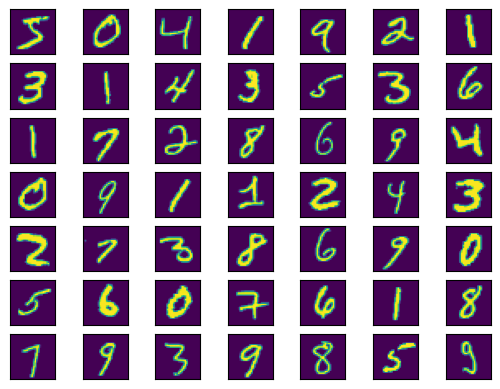

In [56]:
# printing the dataset
for i in range(49):
    # fig = plt.figure()
    # fig.add_subplot(7,7,i+1)
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(x_train[i])
    # fig = plt.figure()
    # fig.add_subplot()
    plt.savefig('/content/output images ')
    # saveImage(fig,i)
plt.show()
#plt.savefig('my_plot.png')

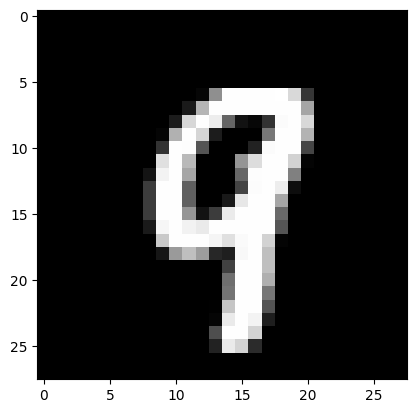

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [57]:
# checking shape of train and test
index = 800
plt.imshow(x_train[index],cmap='gray')
plt.show()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [58]:
# creating the generator using CNN layers
num =100
#weight_init = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
channels = 1
def Generator():
  model= tf.keras.models.Sequential([
      # 1d array for random noise
      tfl.Dense(7*7*256, use_bias='False',input_shape=[num]),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      tfl.Reshape([7, 7, 256]),

      # upsample to 14x14
      tfl.Conv2DTranspose(128, (5,5), (1,1), padding="same"),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      # upsample to 28x28
      tfl.Conv2DTranspose(64, (5,5), (2,2), padding="same"),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      tfl.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
  ])
  return model

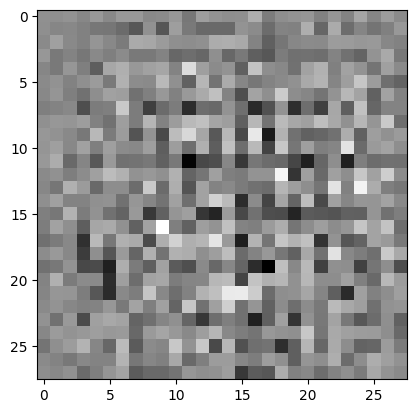

In [59]:
#initialising the generator
generator = Generator()
noise = tf.random.normal(shape=[1, num])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0],cmap='gray')

In [60]:
# creating the discriminator using CNN layers
def Discriminator():
    model = keras.models.Sequential([
        tfl.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Conv2D(128, (5,5), (2,2), padding="same"),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Conv2D(256, (5,5), (1,1), padding="same"),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Flatten(),
        tfl.Dense(1, activation='sigmoid')
    ])
    return model


In [61]:
# initialising the discriminator
discriminator = Discriminator()
prob = discriminator(generated_image)
print(prob)

tf.Tensor([[0.50016165]], shape=(1, 1), dtype=float32)


In [62]:
# putting the generator and discriminator together
class DCGAN(keras.Model):
  def __init__(self,generator,discriminator, num):
    super().__init__()
    self.generator = generator
    self.discriminator = discriminator
    # self.g_metric = keras.metrics(name='g_loss')
    # self.d_metric = keras.Mean(name='d_loss')
    self.g_metric = keras.metrics.Mean(name='g_loss')
    self.d_metric = keras.metrics.Mean(name='d_loss')

  def metric(self):
    # return [g_metric,d_metric]
    return [self.g_metric, self.d_metric]

  def compile(self, g_optimizer,d_optimizer,loss):
    super(DCGAN,self).compile()


In [63]:
# training the now formed DCGAN
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, num):
        super().__init__()
        #generator = generator
        #discriminator = discriminator
        self.generator = generator
        self.discriminator = discriminator
        self.num = num
        self.g_metric = keras.metrics.Mean(name='g_loss')
        self.d_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        #return [g_metric,d_metric]
        return [self.g_metric, self.d_metric]

    def compile(self, g_optimizer, d_optimizer, loss):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss = loss

    def train_step(self, real_images):
        #batch_size = self.shape(real_images)[0]
        #batch_size = tf.shape(real_images[0])
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.num))

        # training the discriminator
        with tf.GradientTape() as tape:
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss(real_labels, pred_real)

            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss(fake_labels, pred_fake)

            # calculating total loss by discriminator
            d_loss = (d_loss_real + d_loss_fake) / 2


        # gradient descent for discriminator
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # training the generator
        labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)

            # calculating total loss by generator
            g_loss = self.loss(labels, pred_fake)

        # gradient descent for generator
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        self.d_metric.update_state(d_loss)
        self.g_metric.update_state(g_loss)

        return {'d_loss': self.d_metric.result(), 'g_loss': self.g_metric.result()}

In [64]:
# compiling and running it on train dataset
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        g_img = self.model.generator(self.noise)
        g_img = (g_img * 127.5) + 127.5
        #g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            #img = array_to_img(g_img[i])
            plt.imshow(g_img[i],cmap='gray')
            plt.axis('off')
            # plt.savefig('Epoch.jpg'.format(i))
            # plt.close()
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

Epoch 1/50
187/188 [============================>.] - ETA: 0s - d_loss: 1.4992 - g_loss: 0.0922

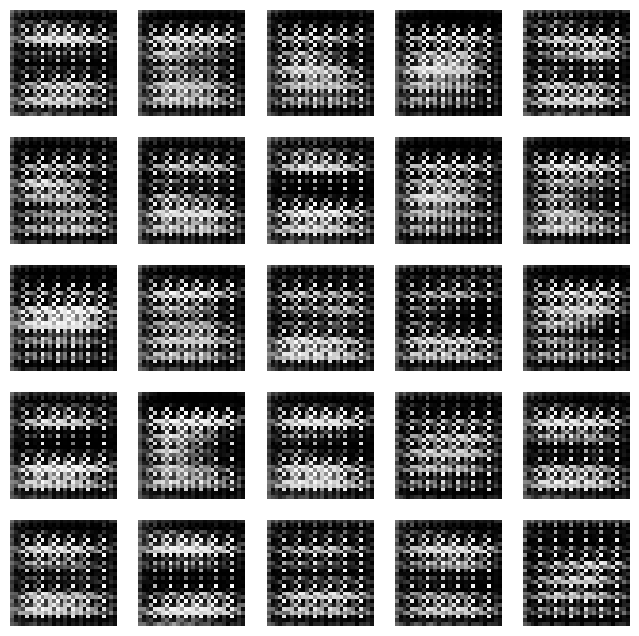

188/188 [==============================] - 10s 26ms/step - d_loss: 1.4900 - g_loss: 0.0918
Epoch 2/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.3760 - g_loss: 0.3830

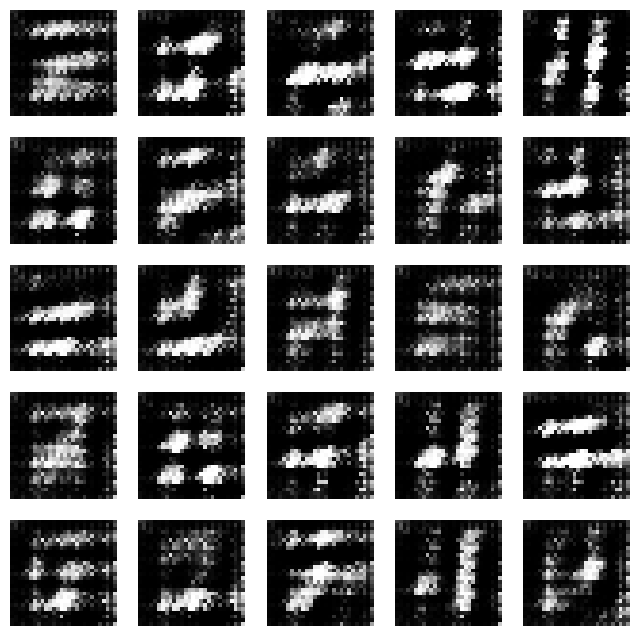

188/188 [==============================] - 4s 22ms/step - d_loss: 0.3773 - g_loss: 0.3837
Epoch 3/50
185/188 [============================>.] - ETA: 0s - d_loss: 0.6992 - g_loss: 0.6758

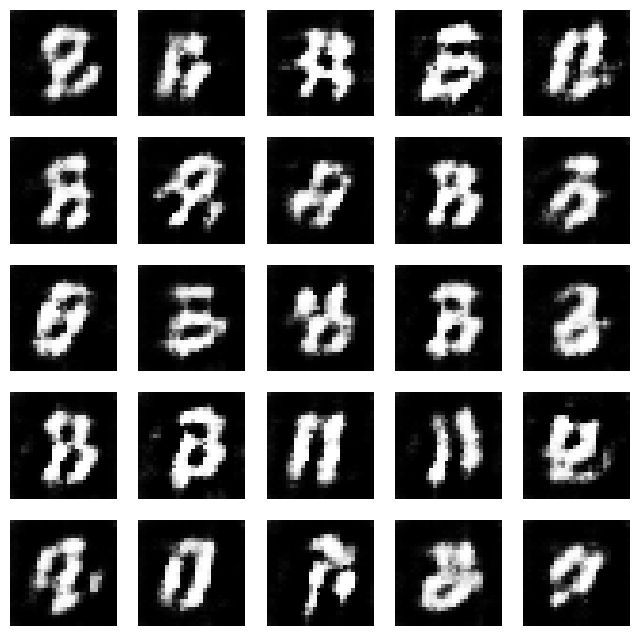

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6997 - g_loss: 0.6770
Epoch 4/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.7197 - g_loss: 0.7243

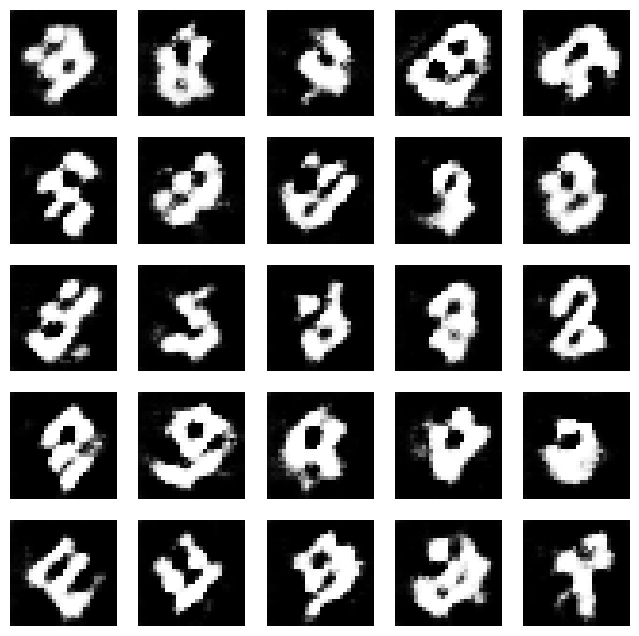

188/188 [==============================] - 4s 23ms/step - d_loss: 0.7209 - g_loss: 0.7271
Epoch 5/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6871 - g_loss: 0.7617

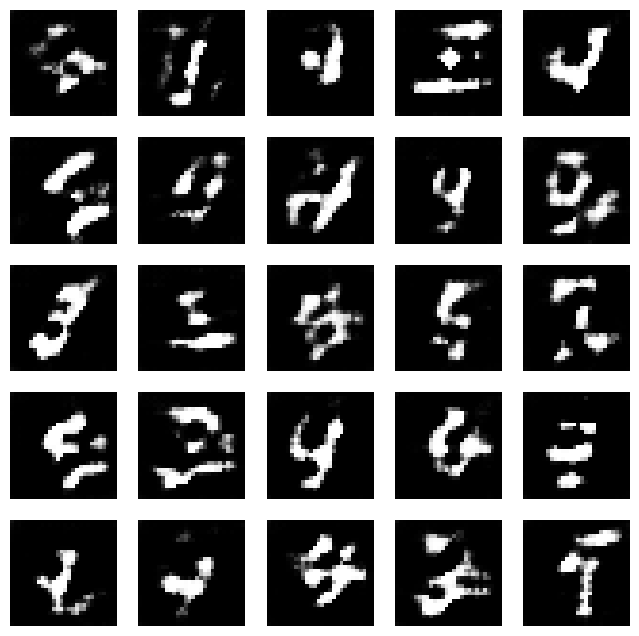

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6872 - g_loss: 0.7615
Epoch 6/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6908 - g_loss: 0.7426

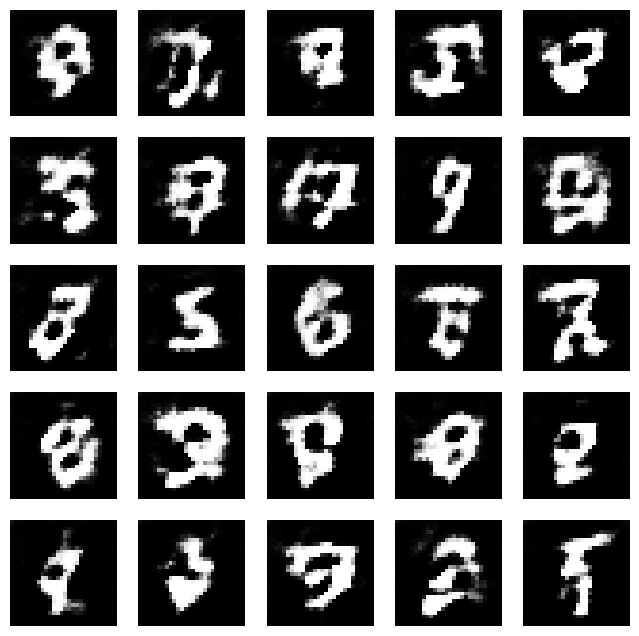

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6905 - g_loss: 0.7427
Epoch 7/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6759 - g_loss: 0.7402

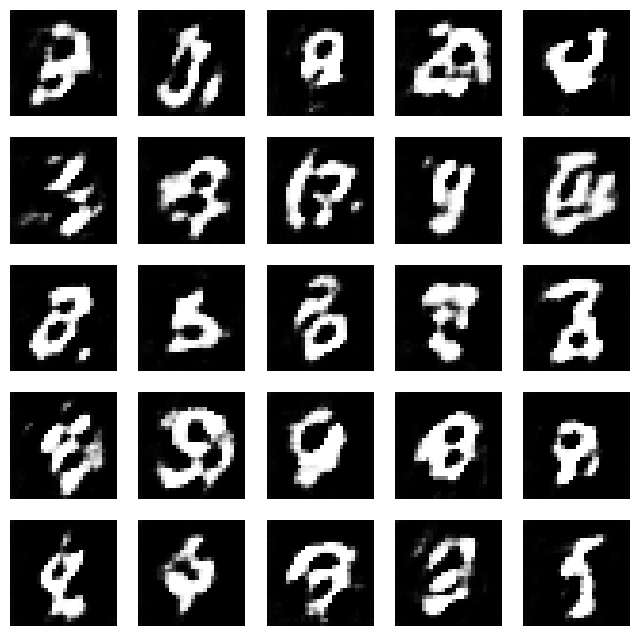

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6759 - g_loss: 0.7402
Epoch 8/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6682 - g_loss: 0.7531

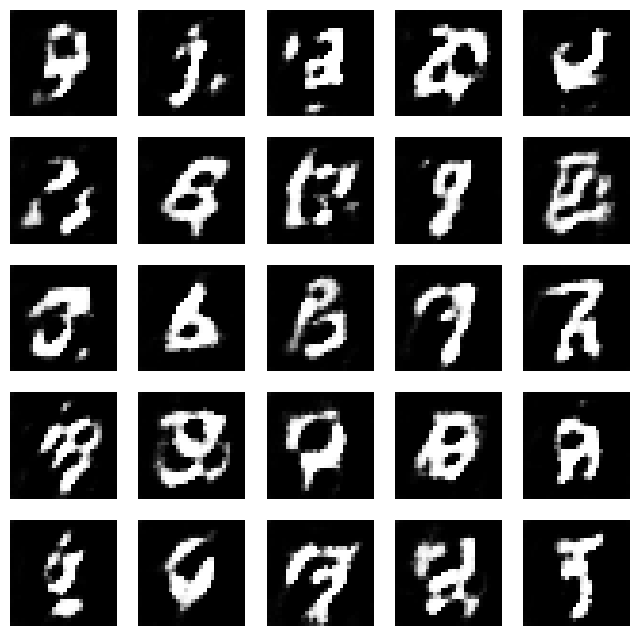

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6694 - g_loss: 0.7524
Epoch 9/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6676 - g_loss: 0.7590

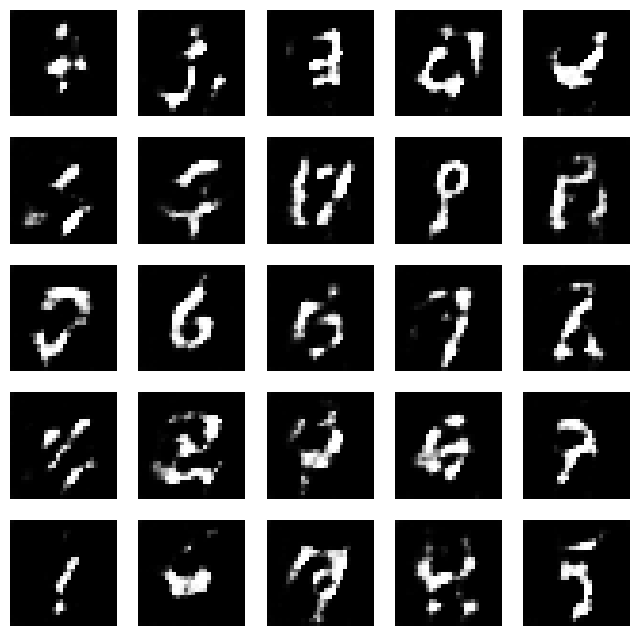

188/188 [==============================] - 4s 24ms/step - d_loss: 0.6676 - g_loss: 0.7584
Epoch 10/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6651 - g_loss: 0.7737

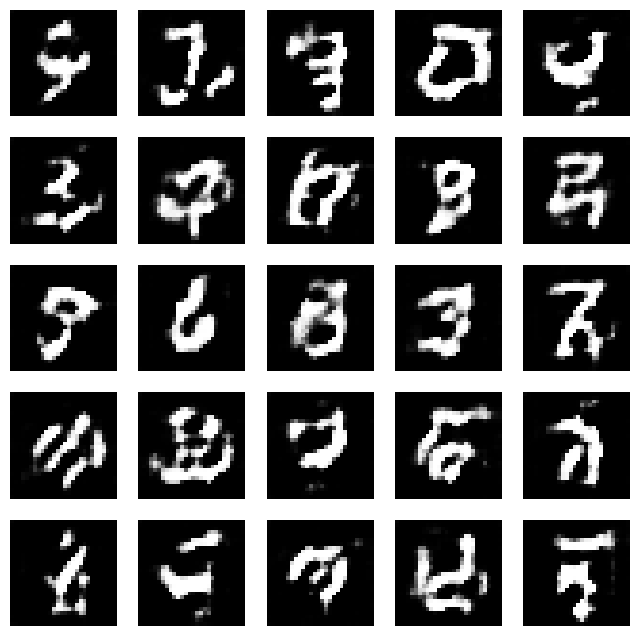

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6651 - g_loss: 0.7737
Epoch 11/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6619 - g_loss: 0.7764

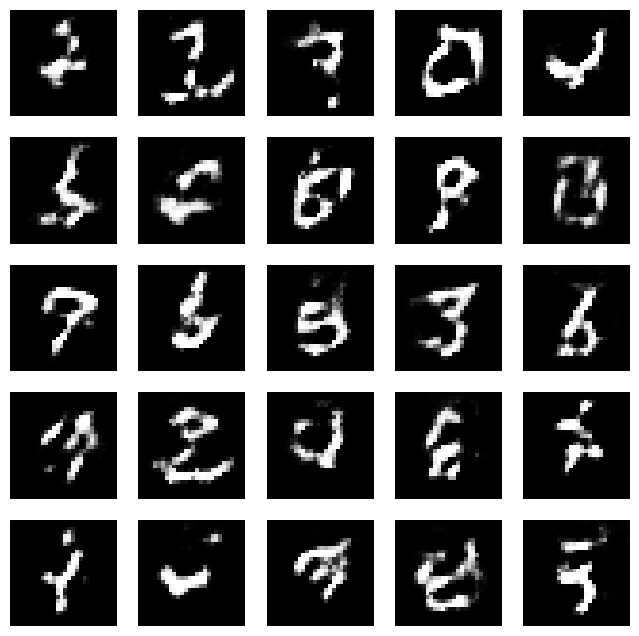

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6620 - g_loss: 0.7760
Epoch 12/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6584 - g_loss: 0.7716

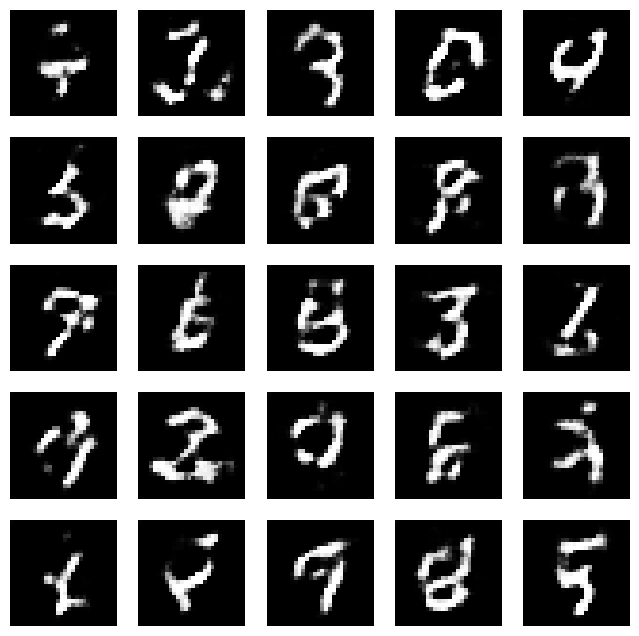

188/188 [==============================] - 4s 24ms/step - d_loss: 0.6584 - g_loss: 0.7716
Epoch 13/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6648 - g_loss: 0.7767

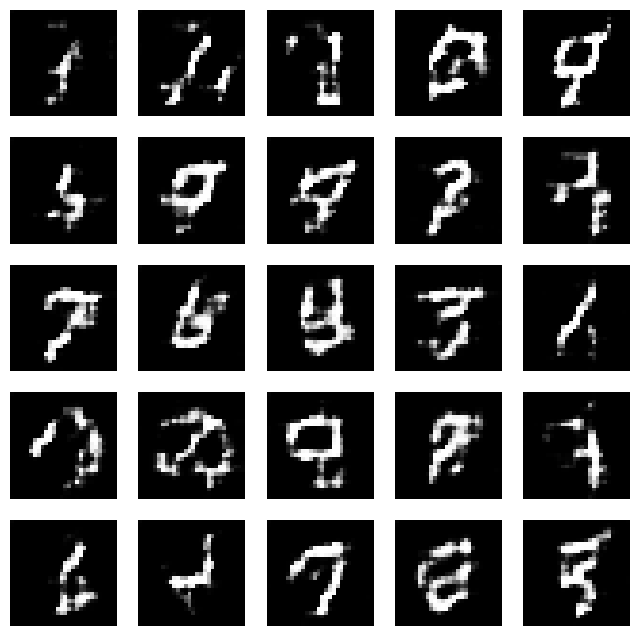

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6648 - g_loss: 0.7767
Epoch 14/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6592 - g_loss: 0.7658

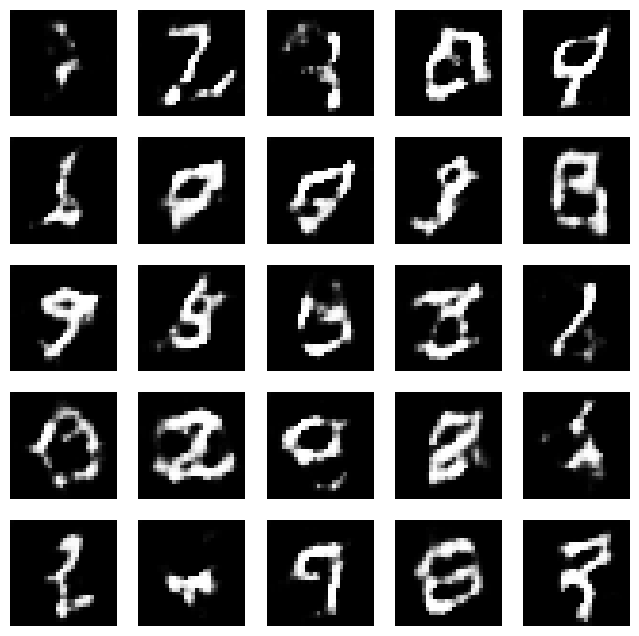

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6592 - g_loss: 0.7658
Epoch 15/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6640 - g_loss: 0.7699

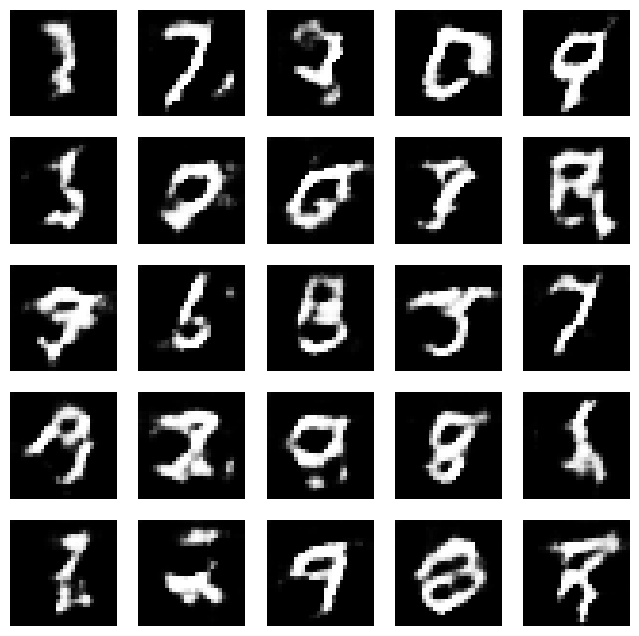

188/188 [==============================] - 5s 26ms/step - d_loss: 0.6640 - g_loss: 0.7699
Epoch 16/50
185/188 [============================>.] - ETA: 0s - d_loss: 0.6586 - g_loss: 0.7639

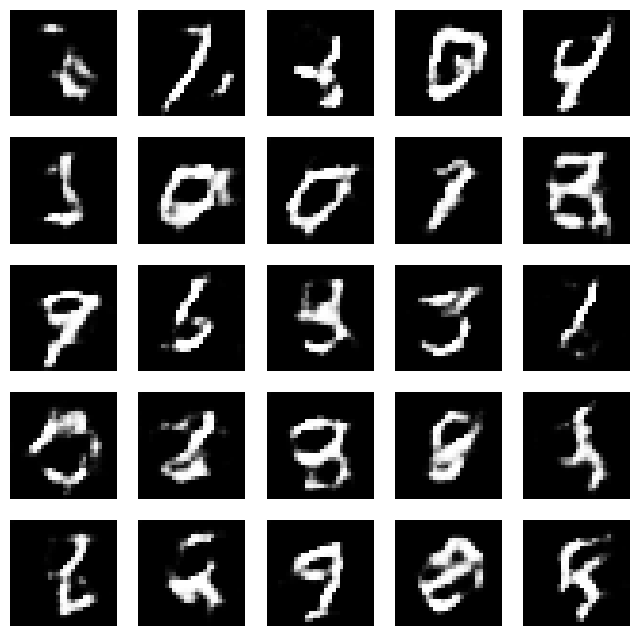

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6585 - g_loss: 0.7637
Epoch 17/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6605 - g_loss: 0.7861

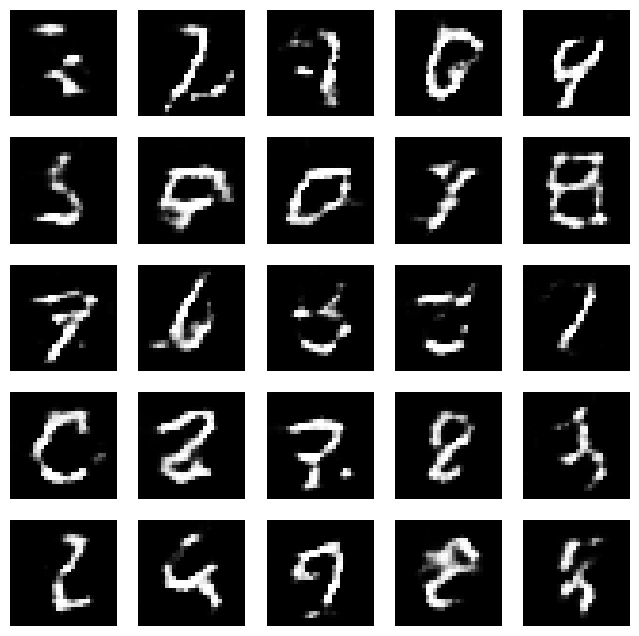

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6605 - g_loss: 0.7861
Epoch 18/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6568 - g_loss: 0.7740

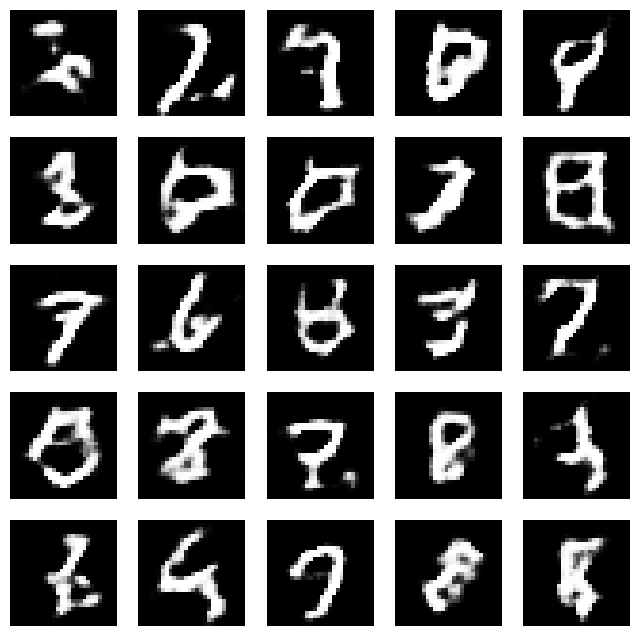

188/188 [==============================] - 5s 26ms/step - d_loss: 0.6573 - g_loss: 0.7733
Epoch 19/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6579 - g_loss: 0.7822

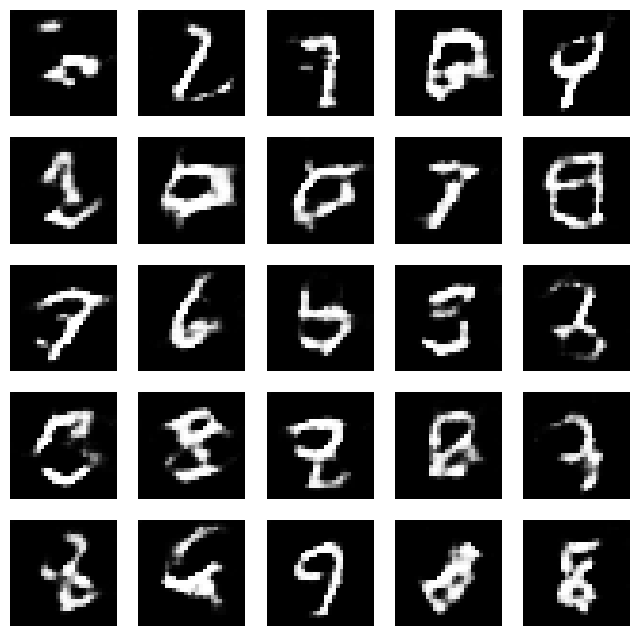

188/188 [==============================] - 5s 26ms/step - d_loss: 0.6581 - g_loss: 0.7817
Epoch 20/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6603 - g_loss: 0.7726

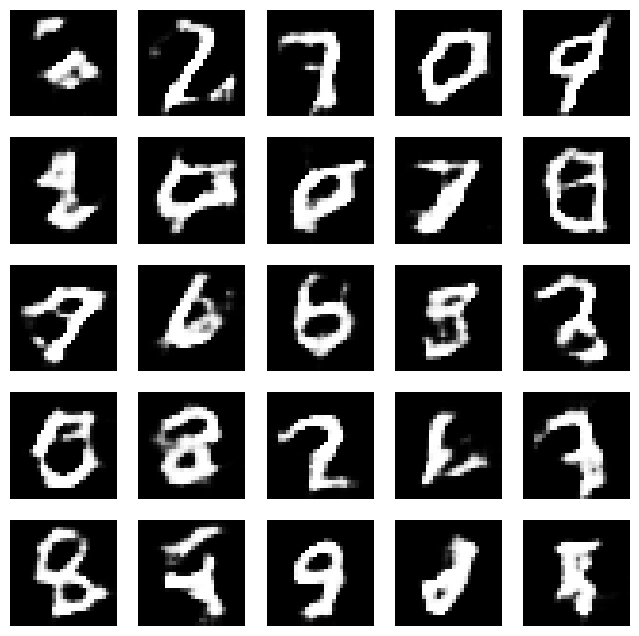

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6603 - g_loss: 0.7726
Epoch 21/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6527 - g_loss: 0.7873

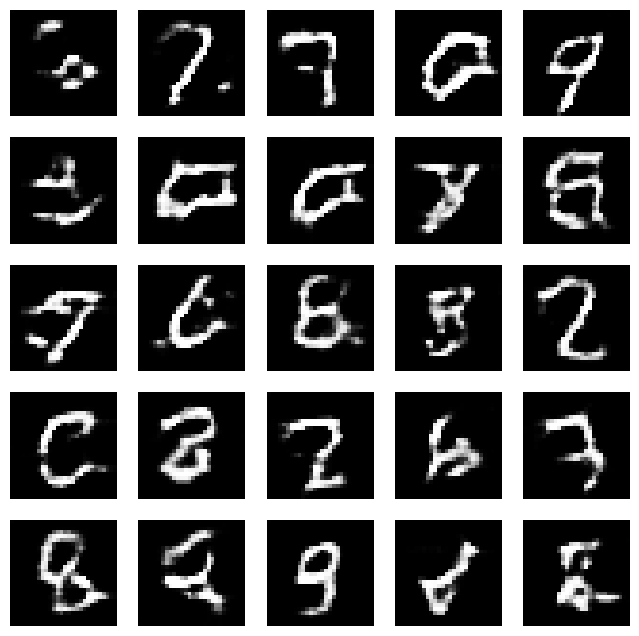

188/188 [==============================] - 5s 26ms/step - d_loss: 0.6530 - g_loss: 0.7876
Epoch 22/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6501 - g_loss: 0.7739

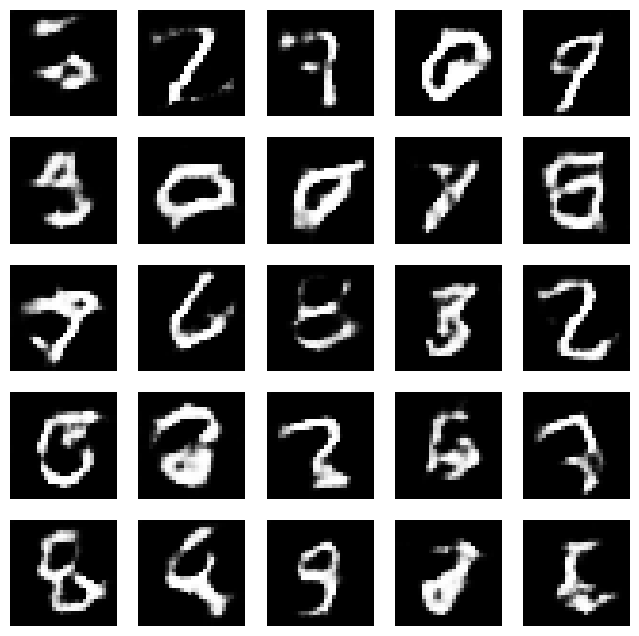

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6498 - g_loss: 0.7740
Epoch 23/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6500 - g_loss: 0.7940

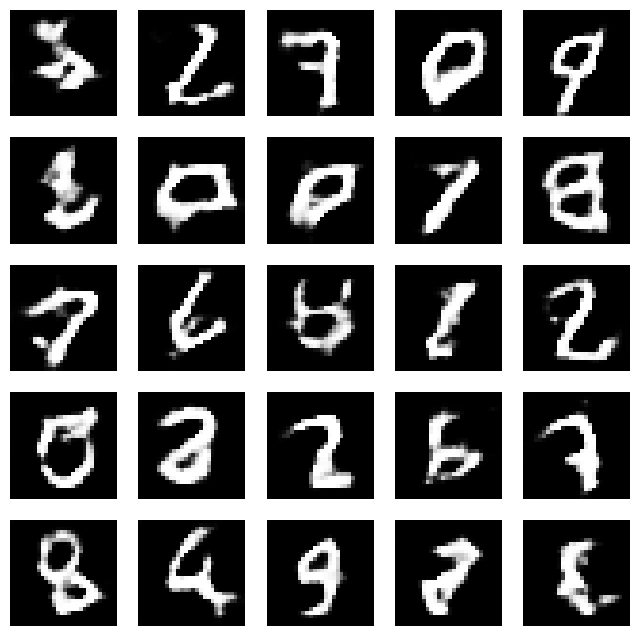

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6500 - g_loss: 0.7942
Epoch 24/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6464 - g_loss: 0.7821

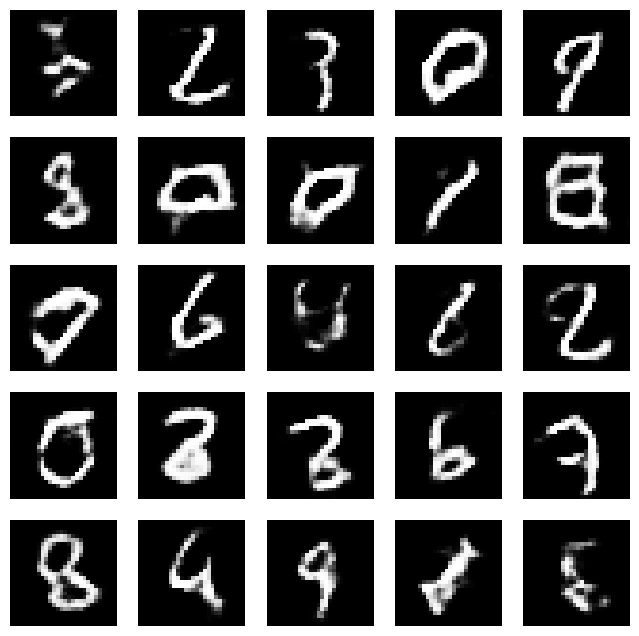

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6464 - g_loss: 0.7821
Epoch 25/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6451 - g_loss: 0.8127

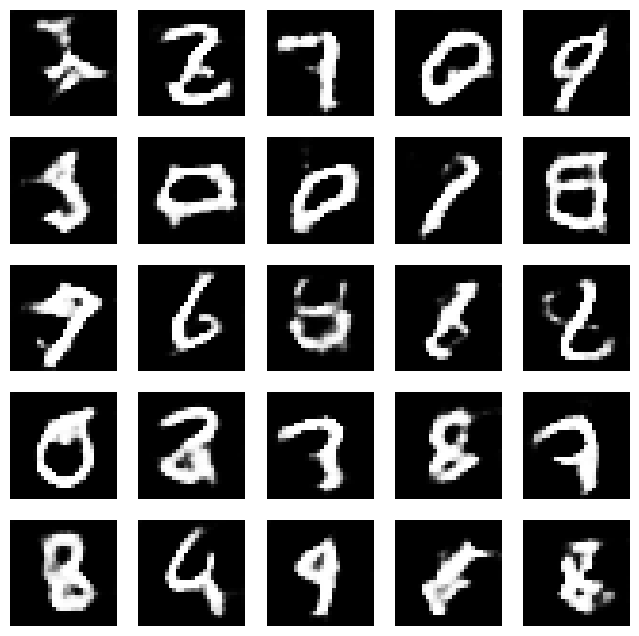

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6451 - g_loss: 0.8127
Epoch 26/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6406 - g_loss: 0.8044

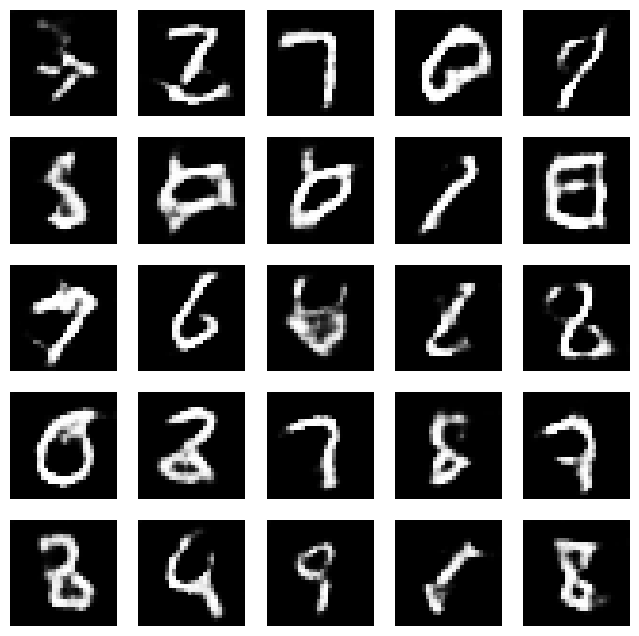

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6404 - g_loss: 0.8043
Epoch 27/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6417 - g_loss: 0.8273

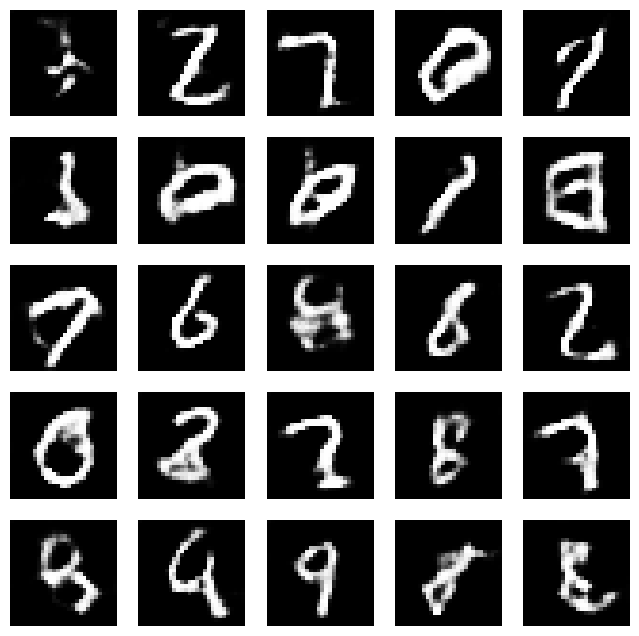

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6420 - g_loss: 0.8271
Epoch 28/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6366 - g_loss: 0.8359

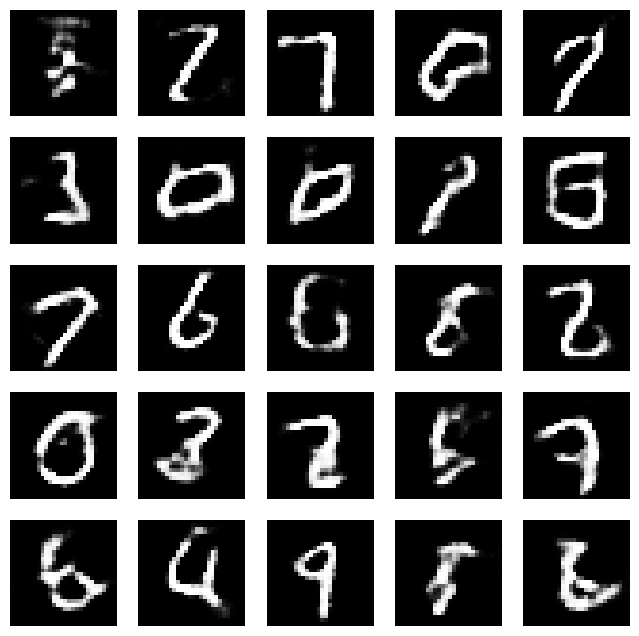

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6366 - g_loss: 0.8359
Epoch 29/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6346 - g_loss: 0.8116

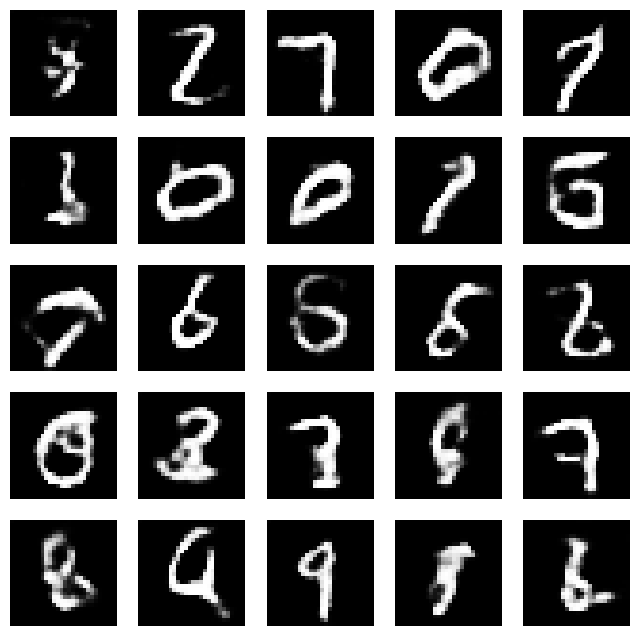

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6346 - g_loss: 0.8115
Epoch 30/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6333 - g_loss: 0.8394

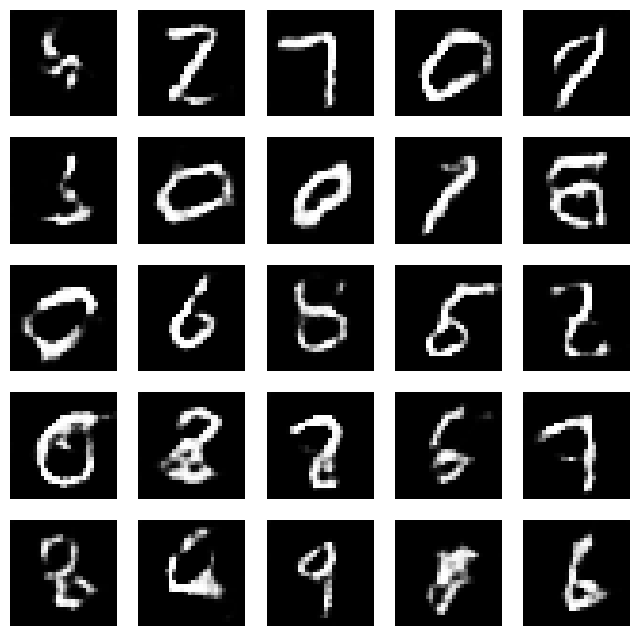

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6333 - g_loss: 0.8394
Epoch 31/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6330 - g_loss: 0.8314

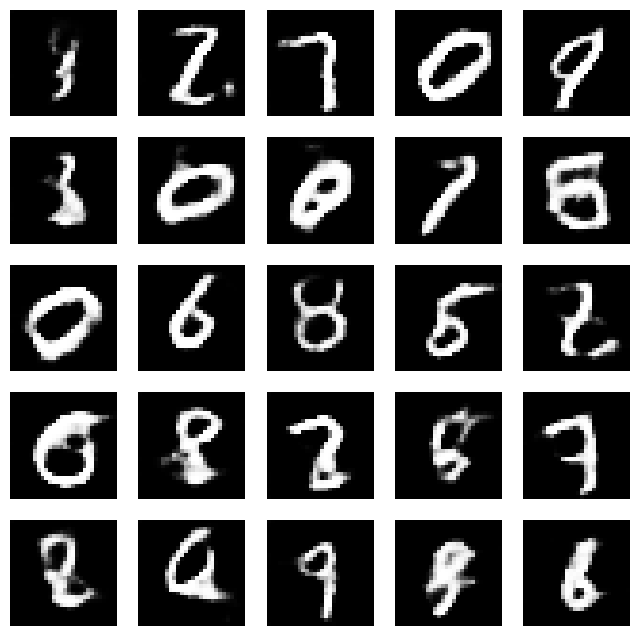

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6330 - g_loss: 0.8313
Epoch 32/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6251 - g_loss: 0.8713

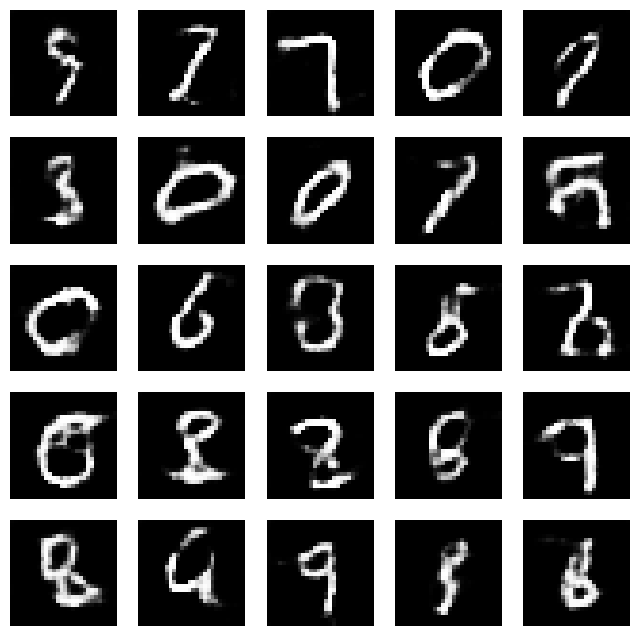

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6256 - g_loss: 0.8716
Epoch 33/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6190 - g_loss: 0.8643

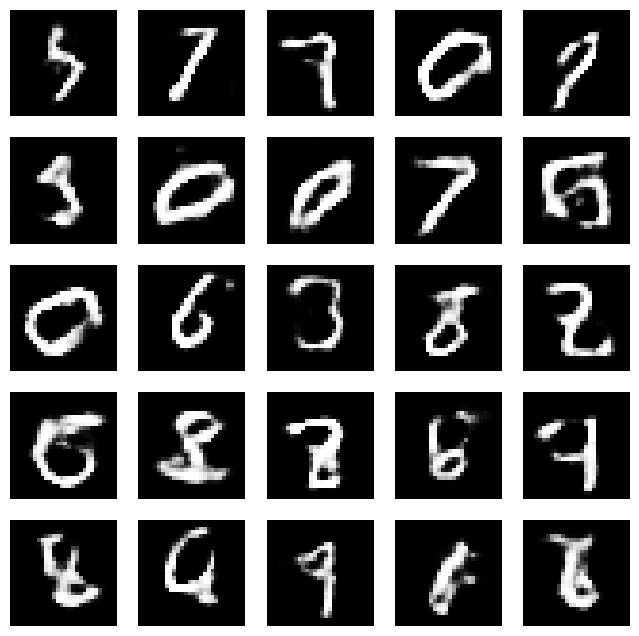

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6196 - g_loss: 0.8639
Epoch 34/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6190 - g_loss: 0.8789

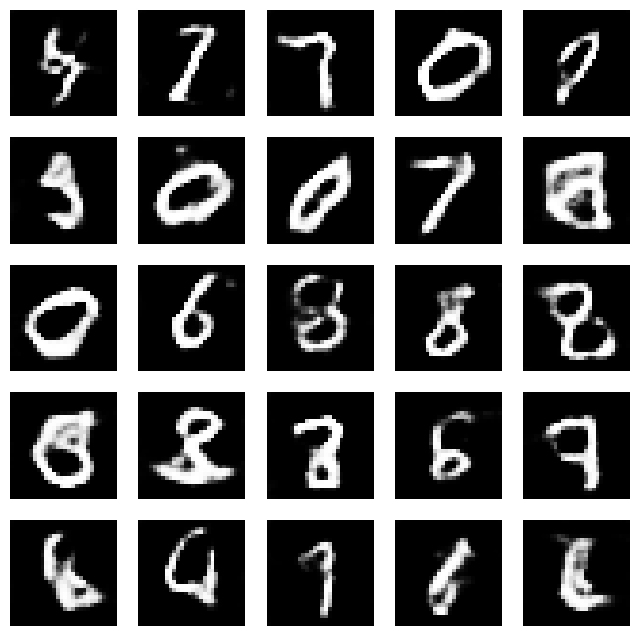

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6188 - g_loss: 0.8778
Epoch 35/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6203 - g_loss: 0.8707

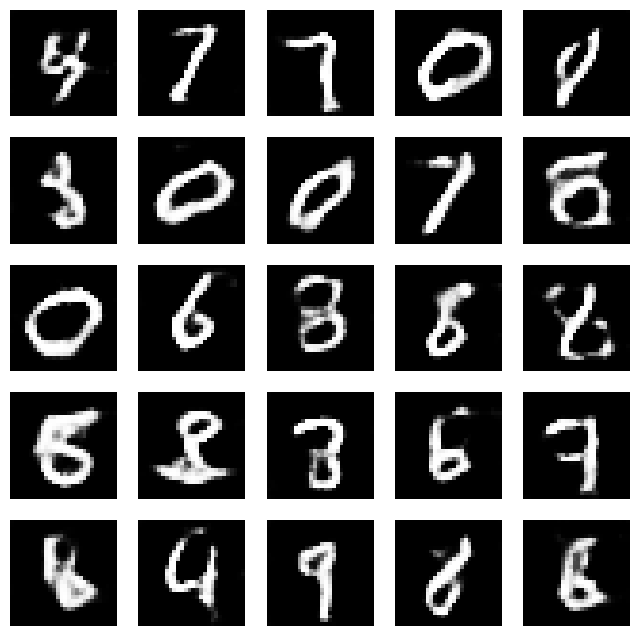

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6201 - g_loss: 0.8713
Epoch 36/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6166 - g_loss: 0.8909

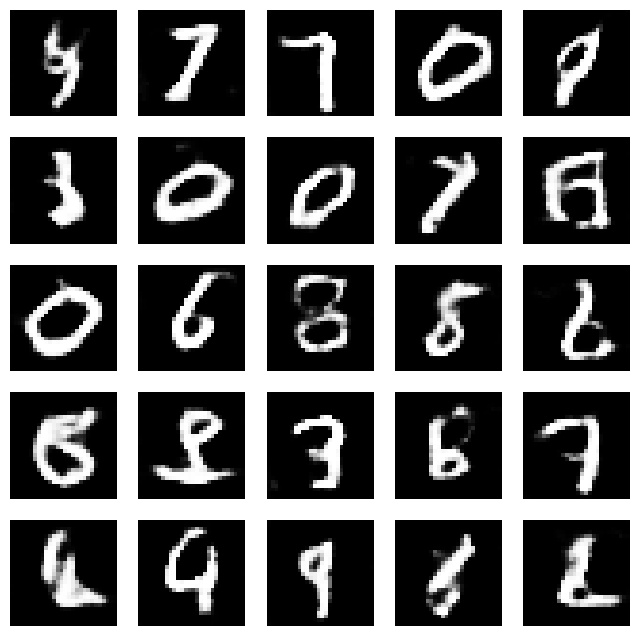

188/188 [==============================] - 5s 26ms/step - d_loss: 0.6173 - g_loss: 0.8896
Epoch 37/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6152 - g_loss: 0.8923

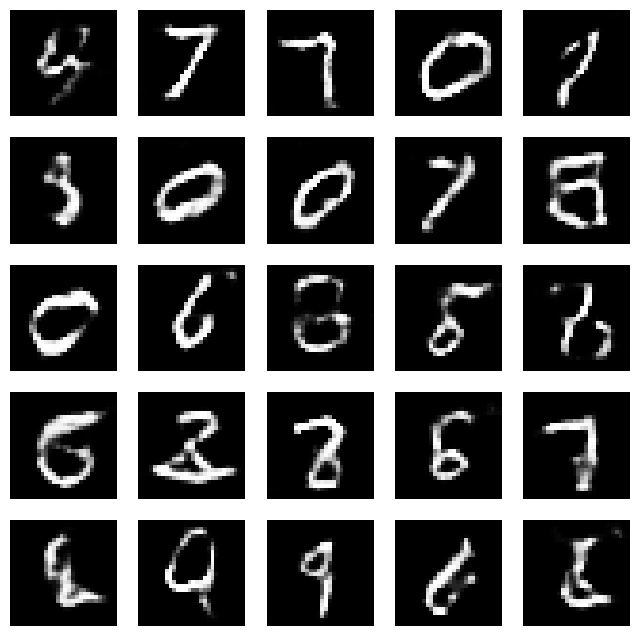

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6161 - g_loss: 0.8932
Epoch 38/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6129 - g_loss: 0.8813

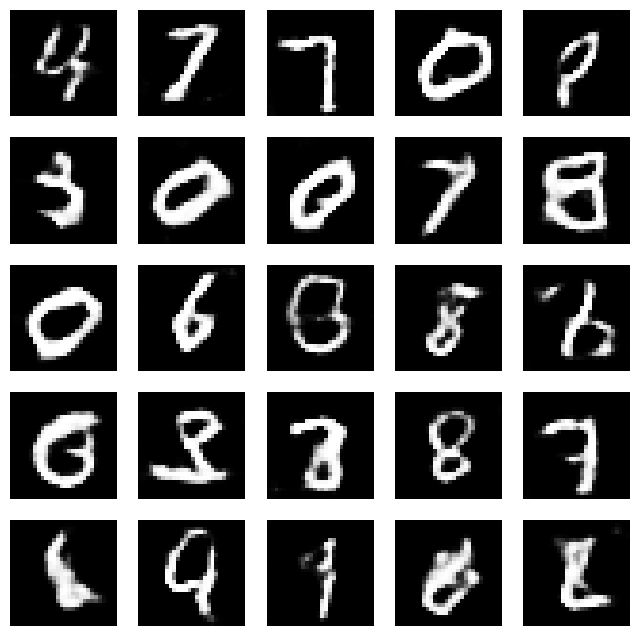

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6129 - g_loss: 0.8809
Epoch 39/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6056 - g_loss: 0.8977

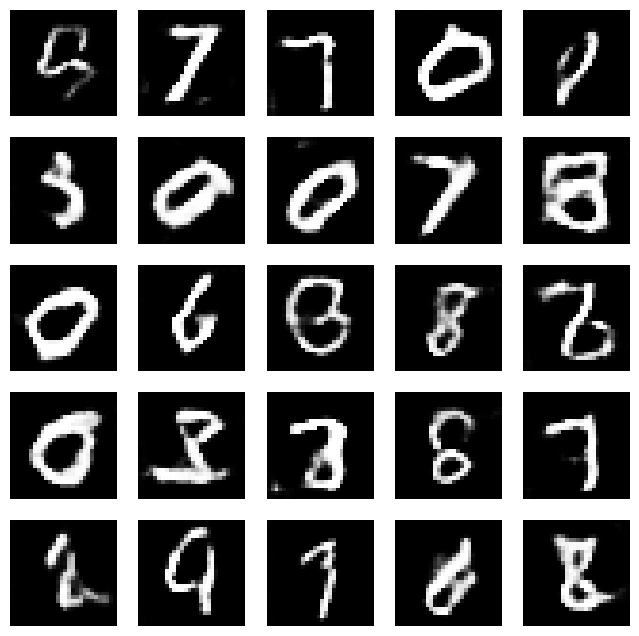

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6055 - g_loss: 0.8977
Epoch 40/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6080 - g_loss: 0.9091

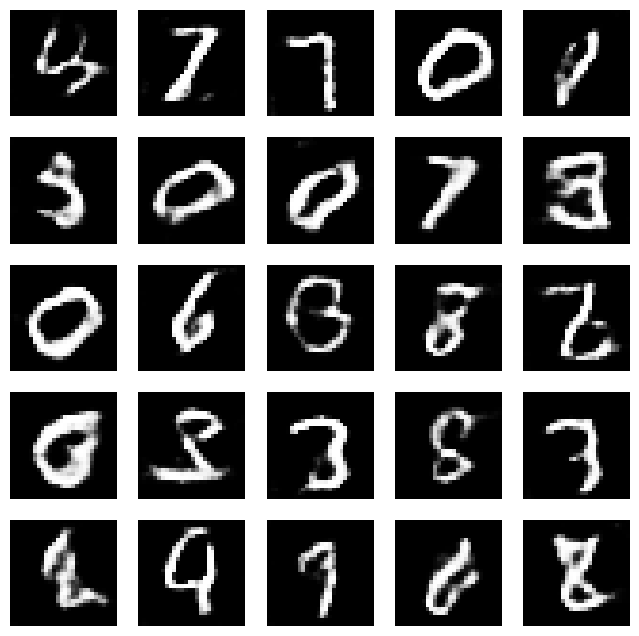

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6080 - g_loss: 0.9086
Epoch 41/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6059 - g_loss: 0.9040

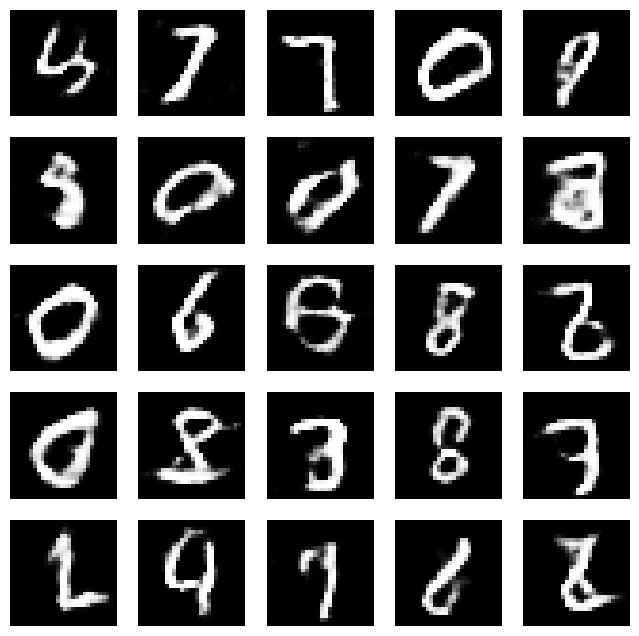

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6058 - g_loss: 0.9051
Epoch 42/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6045 - g_loss: 0.9097

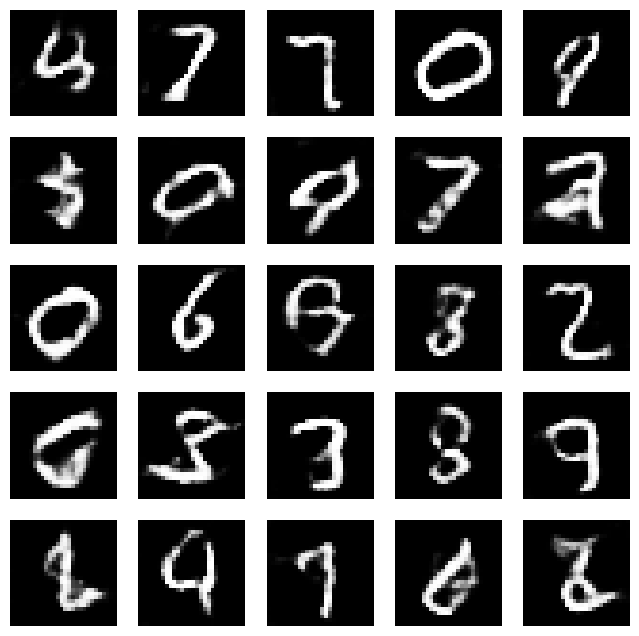

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6041 - g_loss: 0.9123
Epoch 43/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6052 - g_loss: 0.9138

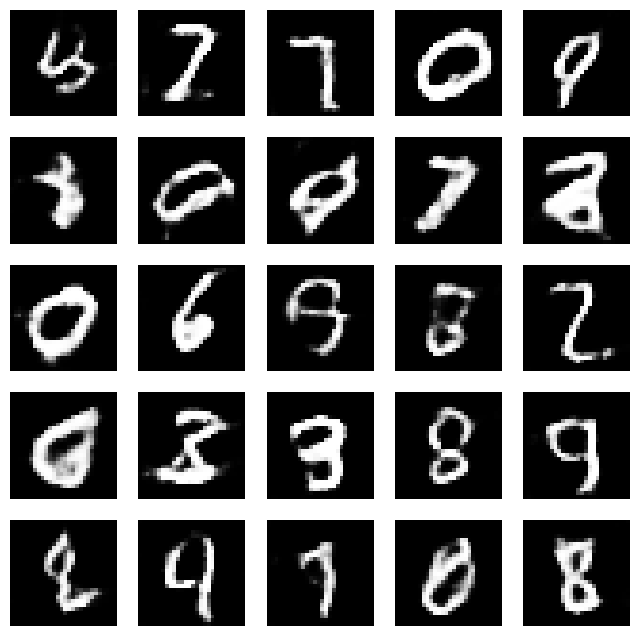

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6052 - g_loss: 0.9120
Epoch 44/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6069 - g_loss: 0.9244

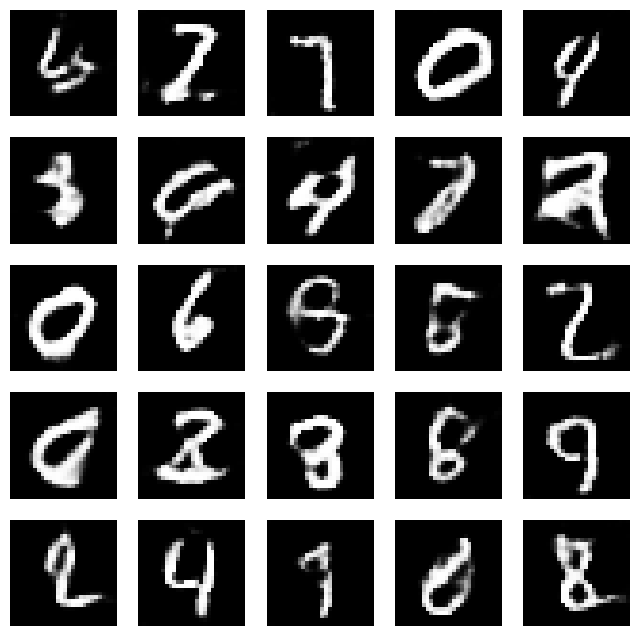

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6072 - g_loss: 0.9259
Epoch 45/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5984 - g_loss: 0.9322

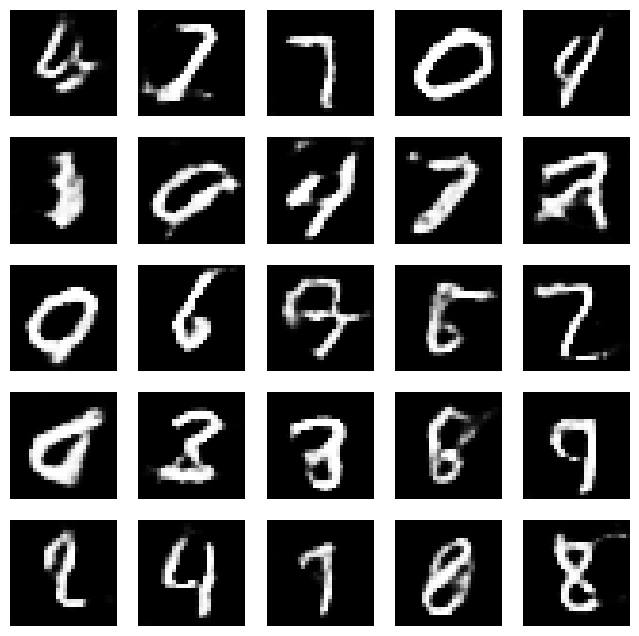

188/188 [==============================] - 5s 25ms/step - d_loss: 0.5984 - g_loss: 0.9329
Epoch 46/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5979 - g_loss: 0.9239

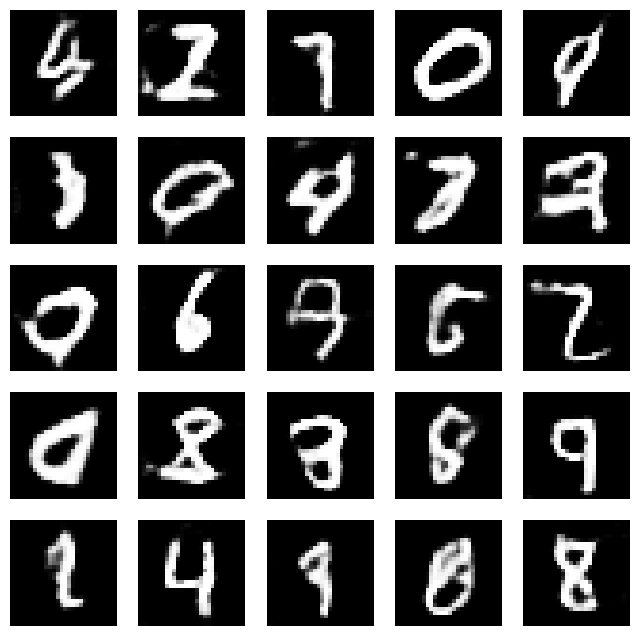

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5979 - g_loss: 0.9239
Epoch 47/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5972 - g_loss: 0.9448

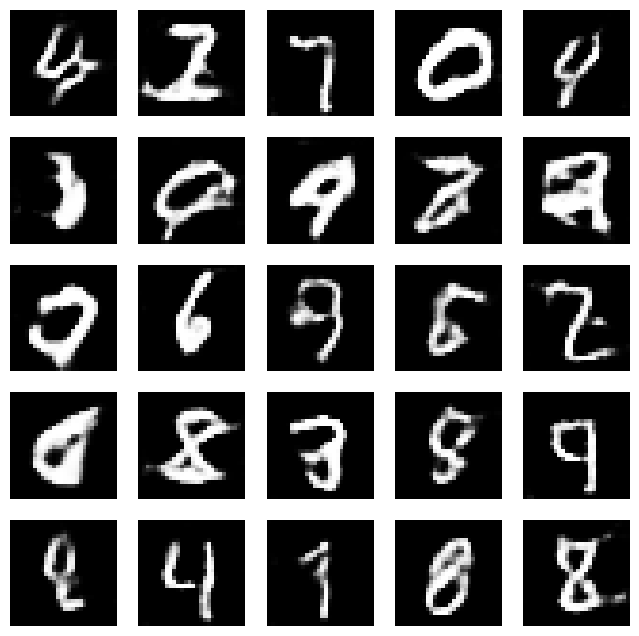

188/188 [==============================] - 5s 25ms/step - d_loss: 0.5972 - g_loss: 0.9456
Epoch 48/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5930 - g_loss: 0.9245

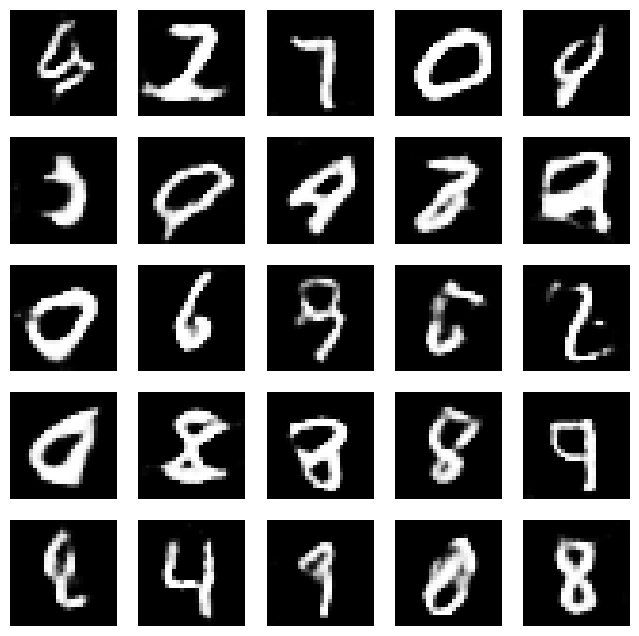

188/188 [==============================] - 5s 24ms/step - d_loss: 0.5929 - g_loss: 0.9259
Epoch 49/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5969 - g_loss: 0.9554

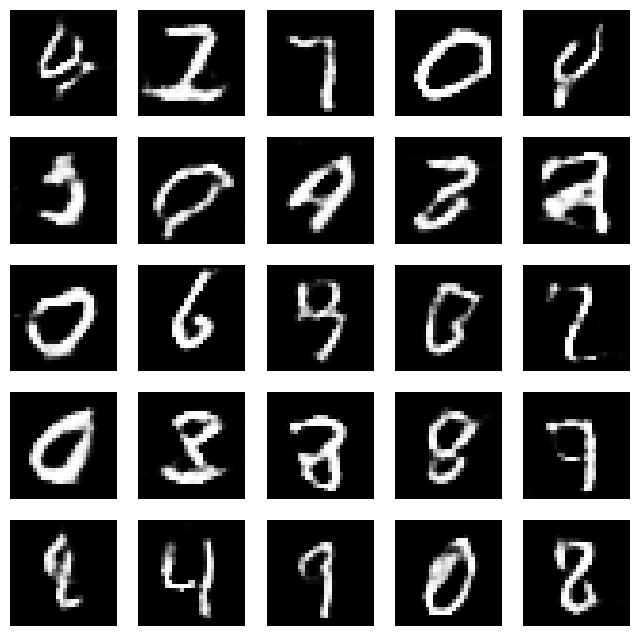

188/188 [==============================] - 4s 22ms/step - d_loss: 0.5976 - g_loss: 0.9547
Epoch 50/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5992 - g_loss: 0.9434

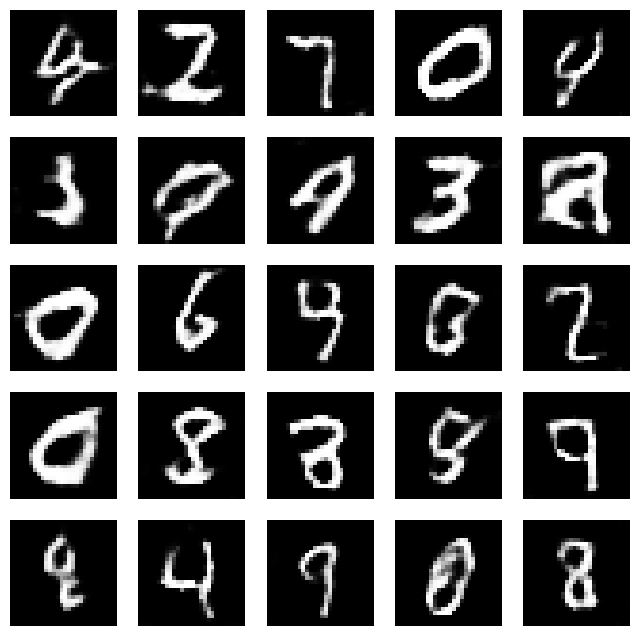

188/188 [==============================] - 5s 26ms/step - d_loss: 0.5991 - g_loss: 0.9436


In [65]:
# setting initial parameter values and then applying optimizers while compiling
dcgan = DCGAN(generator=generator, discriminator=discriminator, num=num)
d = 0.0001
g = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=g, beta_1=0.5), d_optimizer=Adam(learning_rate=d, beta_1=0.5), loss=BinaryCrossentropy())
number_epochs = 50
dcgan.fit(x_train[:6000], epochs=number_epochs , callbacks=[DCGANMonitor()])